### Автор: <i>Северин Никита</i>

Выражаю благодарность Игорю Дьяченко за тестовые примеры и скрипт для их парсинга!

In [1]:
!pip install pycosat
!git clone -q https://github.com/Nikis14/MIPT-visualization-hw

     |████████████████████████████████| 71kB 2.9MB/s 
  Created wheel for pycosat: filename=pycosat-0.6.3-cp37-cp37m-linux_x86_64.whl size=143819 sha256=cbf1686fc52af7ef7ed03696ffc68c134121a2b02b4d6c54680869bd1b8774bf
  Stored in directory: /root/.cache/pip/wheels/c4/67/ff/5570304e45814eccef48a3c69c3af25d0456ed3a34eddbbe38
Successfully built pycosat


In [2]:
import pycosat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from itertools import chain, combinations

In [3]:
class Pos:
    """Класс позиции на холсте"""
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = arr
    
    def __add__(self, that):
        return Pos(*[a + b for a, b in zip(self.xy, that.xy)])
    
    def __sub__(self, that):
        return Pos(*[a - b for a, b in zip(self.xy, that.xy)])
    
    def __neg__(self):
        return Pos(*[-a for a in self.xy])
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)


class Box:
    """Класс прямоугольника и точки"""
    border_x = 500
    border_y = 500

    def __init__(self, line, start_num=1):
        arr = line.split('\t')
        self.pos = Pos.parse(arr[0])
        self.size = Pos.parse(arr[1])
        self.offsets = self._fill_offsets(arr[2].split(' '))
        self.props = [start_num + i for i in range(len(self.offsets))]
        self.start_num = start_num
        assert len(self.offsets) > 0
    
    def _fill_offsets(self, lst):
        offsets = []
        for pos_str in lst:
            cur_pos = Pos.parse(pos_str)
            left_down = self.pos - cur_pos
            right_up = left_down + self.size
            if all([coord >= 0 for coord in left_down.xy]) and\
            all([coord <= 500 for coord in right_up.xy]):
                 offsets.append(cur_pos)
        return offsets

    def __str__(self):
        return 'Box(pos={}, size={}, offsets={}, props={})'.\
                    format(self.pos, self.size, self.offsets, self.props)
    
    def __repr__(self):
        return str(self)


def read_input(file_path):
    """Читает файл с данными"""
    with open(file_path, 'r') as f:
        res_boxes = []
        start_num = 1
        for line in f.readlines():
             cur_box = Box(line, start_num)
             res_boxes.append(cur_box)
             start_num += len(cur_box.offsets)
    return res_boxes

def build_prop_to_box(boxes):
    """Ставит в соответсвие каждой переменной объект box"""
    res = {}
    for i in range(len(boxes)):
        for prop in boxes[i].props:
            res[prop] = i
    return res

In [4]:
def powerset(lst):
    """powerset([1,2,3]) --> () (1,2) (1,3) (2,3) (1,2,3)"""
    possible_nums = [0] + list(range(2, len(lst)+1))
    return chain.from_iterable(combinations(lst, r) for r in possible_nums)


def default_conditions(boxes):
    """Создает условия на то, что для каждого квадрата
    может быть выбрано только 1 положение"""
    conditions = []
    for box in boxes:
        power_set = powerset(list(range(len(box.props))))
        for ids in power_set:
            cur_arr = [x for x in box.props]
            for i in ids:
                cur_arr[i] = -cur_arr[i]
            conditions.append(cur_arr)
    return conditions


def create_conditions(boxes):
    """Создает логические условия"""
    def process_x_less(left_down_i, left_down_j, size_i, size_j, cur_condition, elem_to_add):
        if left_down_i.xy[1] < left_down_j.xy[1]: #yi < yj
            if left_down_i.xy[0] + size_i.xy[0] < left_down_j.xy[0] or\
            left_down_i.xy[1] + size_i.xy[1] < left_down_j.xy[1]:
                cur_condition.append(elem_to_add)
        #yi >= yj
        elif left_down_i.xy[0] + size_i.xy[0] < left_down_j.xy[0] or\
        left_down_i.xy[1] > left_down_j.xy[1] + size_j.xy[1]:
            cur_condition.append(elem_to_add)

    conditions = default_conditions(boxes)
    for i in range(len(boxes)-1):
        for j in range(i+1, len(boxes)):
            for off_i in range(len(boxes[i].offsets)):
                left_down_i = boxes[i].pos - boxes[i].offsets[off_i]
                cur_condition = [-boxes[i].props[off_i]]
                for off_j in range(len(boxes[j].offsets)):
                    left_down_j = boxes[j].pos - boxes[j].offsets[off_j]
                    if left_down_i.xy[0] == left_down_j.xy[0] and\
                    left_down_i.xy[1] == left_down_j.xy[1]:
                        continue
                    if left_down_i.xy[0] < left_down_j.xy[0]: #xi < xj
                        process_x_less(left_down_i, left_down_j,
                                    boxes[i].size, boxes[j].size,
                                    cur_condition, boxes[j].props[off_j]
                        )
                    #xi >= xj
                    else:
                        process_x_less(left_down_j, left_down_i,
                                    boxes[j].size, boxes[i].size,
                                    cur_condition, boxes[j].props[off_j]
                        )
                if len(cur_condition) < len(boxes[j].offsets) + 1:
                    conditions.append(cur_condition)
    return conditions

In [5]:
def plot_figures(rectangles, points):
    """Рисует квадраты и соотв. точки на холсте"""
    points_x, points_y = tuple(zip(*points))
    colors = [[np.random.random(), np.random.random(), np.random.random()]
              for _ in range(len(points_x))]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(points_x, points_y, c = colors)

    #add rectangle to plot
    for i in range(len(rectangles)):
        ax.add_patch(Rectangle(rectangles[i][0],
                               rectangles[i][1][0],
                               rectangles[i][1][1],
                               facecolor = colors[i],
                               fill=True))

    #ax.set_xticks(range(0, 501, 20))
    #ax.set_yticks(range(0, 501, 20))
    plt.xticks(rotation=90)
    plt.show()

In [6]:
def full_pipeline(boxes):
    """Полная обработка"""
    prop_to_box = build_prop_to_box(boxes)
    conditions = create_conditions(boxes)
    sat_solution = pycosat.solve(conditions)
    if sat_solution == 'UNSAT':
        print('No solution')
        return
    if sat_solution == 'UNKNOWN':
        print('SAT-solver can\'t calculate solution')
        return
    
    sat_solution = np.array(sat_solution)
    final_props = sat_solution[sat_solution > 0]

    rectangles_to_show = []
    points_to_show = []
    for prop in final_props:
        cur_box = boxes[prop_to_box[prop]]
        left_down = cur_box.pos - cur_box.offsets[prop-cur_box.start_num]
        rectangles_to_show.append((left_down.xy, cur_box.size.xy))
        points_to_show.append(cur_box.pos.xy)
    plot_figures(rectangles_to_show, points_to_show)

Чтение данных и вызов функции для обработки

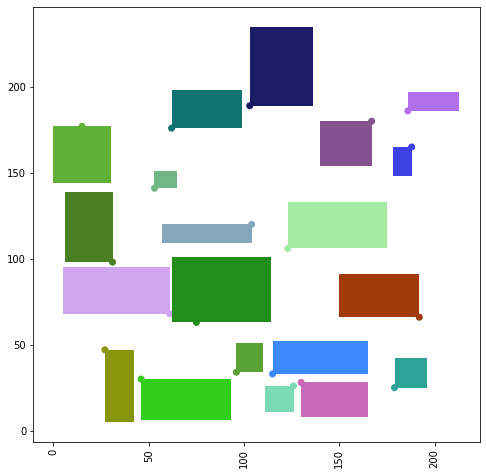

In [8]:
boxes = read_input('MIPT-visualization-hw/hw3-labels/data/hard6.txt')
full_pipeline(boxes)